In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
import nltk
import nltk.corpus
from nltk.tokenize import word_tokenize
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from nltk.tag import pos_tag
from gensim.models import Word2Vec

In [ ]:
def read_and_label_csv(fake_file_path, real_file_path):
    """Read the CSV files and append the "Target" column."""
    fake = pd.read_csv(fake_file_path)
    fake['Target'] = 0

    real = pd.read_csv(real_file_path)
    real['Target'] = 1

    return fake, real

def merge_dataframes(fake, real):
    """Merge the dataframes."""
    return pd.concat([fake, real], axis=0).reset_index(drop=True)

def split_data(df, test_size=0.2, val_size=0.1):
    """Split the merged dataframe into train, test, and validation sets."""
    train_val, test = train_test_split(df, test_size=test_size, random_state=42, stratify=df['Target'])

    train, val = train_test_split(train_val, test_size=val_size, random_state=42, stratify=train_val['Target'])

    return train, val, test


In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from gensim.models import Word2Vec

# Ensure you have the necessary NLTK resources downloaded
nltk.download('averaged_perceptron_tagger')

nltk.download("punkt")
nltk.download("stopwords")


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Text Preprocessing
def preprocess_text(text):
    """
    Preprocess the given text:
    - Convert to lowercase
    - Tokenize
    - Remove stopwords and non-alphabetic tokens
    - Stemming
    """
    text = text.lower()

    tokens = word_tokenize(text)

    tokens = [token for token in tokens if token.isalpha() and token not in stopwords.words('english')]

    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    return " ".join(tokens)

In [ ]:
# POS (Part-of-Speech) Tagging

def get_pos_tags(text):
    """
    Tokenize the text and return the concatenated POS tags.
    """
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    pos_tags = [tag for _, tag in tagged_tokens]
    return " ".join(pos_tags)

In [ ]:
# Word2Vec

def get_word2vec_embeddings(sentences, vector_size=100, window=5, min_count=1, workers=4):
    """
    Train a Word2Vec model on the provided sentences and return the model.
    """
    model = Word2Vec(sentences=sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    return model

def sentence_to_avg_vector(sentence, model):
    """
    Convert a sentence to its average word vector representation using the provided Word2Vec model.
    """
    words = word_tokenize(sentence)
    vectors = [model.wv[word] for word in words if word in model.wv.index_to_key]

    if vectors:
        avg_vector = sum(vectors) / len(vectors)
    else:
        avg_vector = [0] * model.vector_size
    return avg_vector

In [ ]:
# Feature Extraction
def extract_features(train, val, test, method="bow", ngram_range=(1,1)):
    """
    Extract features using the specified method.
    Available methods: "bow" for Bag-of-Words, "tfidf" for TF-IDF
    """
    if method == "bow":
        vectorizer = CountVectorizer(ngram_range=ngram_range)
    elif method == "tfidf":
        vectorizer = TfidfVectorizer(ngram_range=ngram_range)
    else:
        raise ValueError("Invalid method. Choose from 'bow' or 'tfidf'.")

    train_features = vectorizer.fit_transform(train)
    val_features = vectorizer.transform(val)
    test_features = vectorizer.transform(test)

    return train_features, val_features, test_features

In [ ]:
from joblib import Parallel, delayed
from multiprocessing import cpu_count

def preprocess_chunk(chunk):
    return chunk.apply(preprocess_text)

def parallel_preprocessing(data, func=preprocess_chunk, n_jobs=-1):
    """
    Parallelize any function that processes a DataFrame.
    """
    if n_jobs == -1:
        # Use all available cores
        n_jobs = cpu_count()

    # Split the data into chunks for each CPU core
    chunks = np.array_split(data, n_jobs)

    # Use joblib to parallelize the function
    processed_data = Parallel(n_jobs=n_jobs, backend='multiprocessing')(delayed(func)(chunk) for chunk in chunks)

    # Concatenate the processed chunks back into a single Series
    return pd.concat(processed_data)

# # Using parallel preprocessing on the dataframes
# train_df['text'] = parallel_preprocessing(train_df['text'])
# val_df['text'] = parallel_preprocessing(val_df['text'])
# test_df['text'] = parallel_preprocessing(test_df['text'])


In [ ]:
# Data Loading and Splitting
fake, real = read_and_label_csv("/content/Fake.csv", "/content/True.csv")
merged_df = merge_dataframes(fake, real)
train_df, val_df, test_df = split_data(merged_df)

train_df.size

# Preprocessing
train_df['text'] = parallel_preprocessing(train_df['text'])
val_df['text'] = parallel_preprocessing(val_df['text'])
test_df['text'] = parallel_preprocessing(test_df['text'])


# POS tagging
train_df['pos_tags'] = train_df['text'].apply(get_pos_tags)
val_df['pos_tags'] = val_df['text'].apply(get_pos_tags)
test_df['pos_tags'] = test_df['text'].apply(get_pos_tags)

# Feature Extraction
train_features, val_features, test_features = extract_features(train_df['text'], val_df['text'], test_df['text'], method="bow")

# Word2Vec embeddings
sentences = train_df['text'].apply(word_tokenize).tolist()
w2v_model = get_word2vec_embeddings(sentences)
train_df['w2v'] = train_df['text'].apply(lambda x: sentence_to_avg_vector(x, w2v_model))
val_df['w2v'] = val_df['text'].apply(lambda x: sentence_to_avg_vector(x, w2v_model))
test_df['w2v'] = test_df['text'].apply(lambda x: sentence_to_avg_vector(x, w2v_model))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
train_df.to_pickle("/content/drive/MyDrive/train_df.pkl")
val_df.to_pickle("/content/drive/MyDrive/val_df.pkl")
test_df.to_pickle("/content/drive/MyDrive/test_df.pkl")


In [ ]:
train_df = pd.read_pickle("/content/drive/MyDrive/train_df.pkl")
val_df = pd.read_pickle("/content/drive/MyDrive/val_df.pkl")
test_df = pd.read_pickle("/content/drive/MyDrive/test_df.pkl")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
train_df = pd.read_pickle("/content/drive/MyDrive/train_df.pkl")
val_df = pd.read_pickle("/content/drive/MyDrive/val_df.pkl")
test_df = pd.read_pickle("/content/drive/MyDrive/test_df.pkl")

In [ ]:
train_df.to_csv("train_df.csv", index=False)

In [ ]:
test_df.to_csv("test_df.csv", index=False)

In [ ]:
val_df.to_csv("val_df.csv", index=False)

In [ ]:
train_df.head()

,title,text,subject,date,Target,pos_tags,w2v
6408,Bill O’Reilly Pathetically Defends Trump: ‘Je...,fox news host bill reilli fox busi host lou do...,News,"May 12, 2016",0,JJ NN NN NN VBZ JJ NN NN NN NN VBD NN NN NN VB...,"[-0.28598538, -0.26184312, 0.22099337, 0.23066..."
6934,This Important Video Sums Up Why Donald Trump...,despit damag presid georg bush war monger admi...,News,"April 13, 2016",0,NN NN NN VBD JJ NN NN VBP VBN NN NN NN NN NN J...,"[-0.33203617, -0.12083233, 0.1459635, 0.461638..."
38227,"German spy chief sees Russia as danger, cites ...",berlin reuter germani spi chief warn russia se...,worldnews,"November 15, 2017",1,NN NN NN NN NN NN NN VBN JJ NN RB NN JJ JJ NN ...,"[-0.2369827, 0.2080874, 0.066845044, -0.176110..."
44593,U.S. intel official: No doubt North Korea test...,washington reuter intellig offici said sunday ...,worldnews,"September 3, 2017",1,NN NN NN NN VBD JJ NN NN NN NN JJ JJ NN NN JJ ...,"[-0.33601782, -0.17155817, 0.24922632, -0.0068..."
42449,British police release three more men in Londo...,reuter british polic said tuesday releas three...,worldnews,"September 26, 2017",1,NN JJ NN VBD JJ NNS CD NNS VBP NN NN NN NN NN ...,"[-0.17784081, -0.039035708, -0.11823719, 0.146..."


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix

# TF-IDF Vectorizer for POS tags
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_pos = tfidf_vectorizer.fit_transform(train_df['pos_tags'])
X_test_pos = tfidf_vectorizer.transform(test_df['pos_tags'])

# Use w2v features directly as they are already in matrix format
X_train_w2v = np.stack(train_df['w2v'].to_numpy())
X_test_w2v = np.stack(test_df['w2v'].to_numpy())

y_train = train_df['Target']
y_test = test_df['Target']

In [ ]:
# Initialize classifiers
classifiers = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC(),
    "Stochastic Gradient Descent": SGDClassifier(),
    "Random Forest": RandomForestClassifier()
}

In [ ]:
results = {}

for name, clf in classifiers.items():
    # Train on POS tags
    if name != "Naive Bayes":  # Naive Bayes is only suitable for non-negative features like TF-IDF
        clf.fit(X_train_pos, y_train)
        predictions_pos = clf.predict(X_test_pos)
        results[name + " (POS tags)"] = {
            "F1 Score": f1_score(y_test, predictions_pos),
            "Confusion Matrix": confusion_matrix(y_test, predictions_pos)
        }

    # Train on w2v embeddings (skip for Naive Bayes)
    if name != "Naive Bayes":
        clf.fit(X_train_w2v, y_train)
        predictions_w2v = clf.predict(X_test_w2v)
        results[name + " (Word2Vec)"] = {
            "F1 Score": f1_score(y_test, predictions_w2v),
            "Confusion Matrix": confusion_matrix(y_test, predictions_w2v)
        }

print(results)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'Logistic Regression (POS tags)': {'F1 Score': 0.762025608490022, 'Confusion Matrix': array([[3614, 1082],
       [ 981, 3303]])}, 'Logistic Regression (Word2Vec)': {'F1 Score': 0.9639085528606243, 'Confusion Matrix': array([[4516,  180],
       [ 131, 4153]])}, 'Linear SVM (POS tags)': {'F1 Score': 0.7694764457625186, 'Confusion Matrix': array([[3586, 1110],
       [ 911, 3373]])}, 'Linear SVM (Word2Vec)': {'F1 Score': 0.9633750579508578, 'Confusion Matrix': array([[4508,  188],
       [ 128, 4156]])}, 'Stochastic Gradient Descent (POS tags)': {'F1 Score': 0.7431367868226307, 'Confusion Matrix': array([[3715,  981],
       [1171, 3113]])}, 'Stochastic Gradient Descent (Word2Vec)': {'F1 Score': 0.9625952435927037, 'Confusion Matrix': array([[4487,  209],
       [ 115, 4169]])}, 'Random Forest (POS tags)': {'F1 Score': 0.8268635389378424, 'Confusion Matrix': array([[4054,  642],
       [ 812, 3472]])}, 'Random Forest (Word2Vec)': {'F1 Score': 0.9596717467760845, 'Confusion Matrix': arr

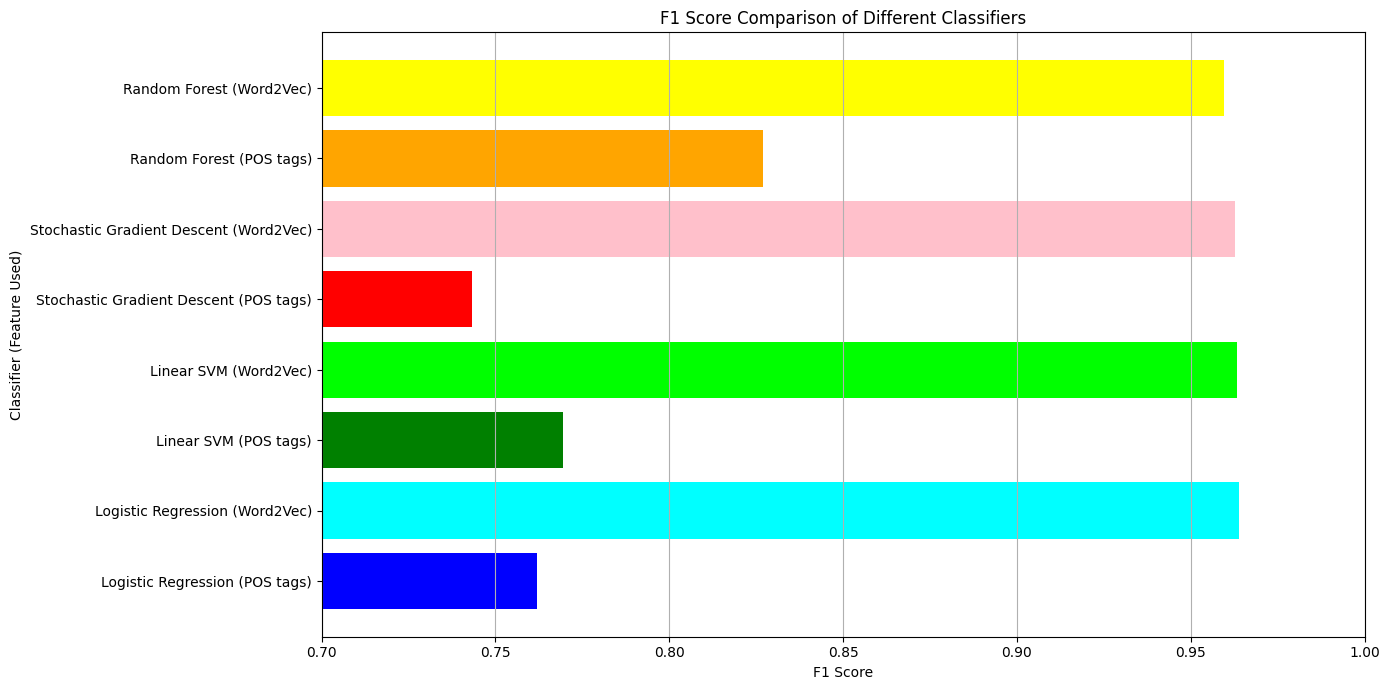

In [ ]:
import matplotlib.pyplot as plt

# Extracting F1 scores for plotting
classifier_names = list(results.keys())
f1_scores = [results[name]["F1 Score"] for name in classifier_names]

plt.figure(figsize=(14, 7))
plt.barh(classifier_names, f1_scores, color=['blue', 'cyan', 'green', 'lime', 'red', 'pink', 'orange', 'yellow'])
plt.xlabel('F1 Score')
plt.ylabel('Classifier (Feature Used)')
plt.title('F1 Score Comparison of Different Classifiers')
plt.xlim(0.7, 1.0)  # Focusing on the range of observed F1 scores
plt.tight_layout()
plt.grid(axis='x')
plt.show()


Word2Vec embeddings consistently outperform POS tags across all classifiers. This indicates the rich semantic information captured by Word2Vec, which is crucial for this fake news classification task.

Logistic Regression, Linear SVM, and Stochastic Gradient Descent have similar performance when trained on Word2Vec embeddings. Random Forest, although slightly more computationally intensive, offers robustness and also performs exceptionally well with Word2Vec.

Given the high F1 scores and computational efficiency, Logistic Regression with Word2Vec embeddings stands out as a top candidate. Random Forest with Word2Vec is also a strong contender, offering robustness and adaptability to potential changes in the type of data.


#### Deciding to proceed with Logistic Regression and Random Forest with Word2Vec Embeddings.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters for Logistic Regression
logistic_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'] # l1 gave non-finite value error
}

# Define hyperparameters for Random Forest
random_forest_params = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
# Hyperparameter tuning for Logistic Regression
logistic_grid = GridSearchCV(LogisticRegression(max_iter=1000), logistic_params, scoring='f1', cv=5)
logistic_grid.fit(X_train_w2v, y_train)
best_logistic_params = logistic_grid.best_params_

In [ ]:
print("Best parameters for Logistic Regression:", best_logistic_params)

Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l2'}


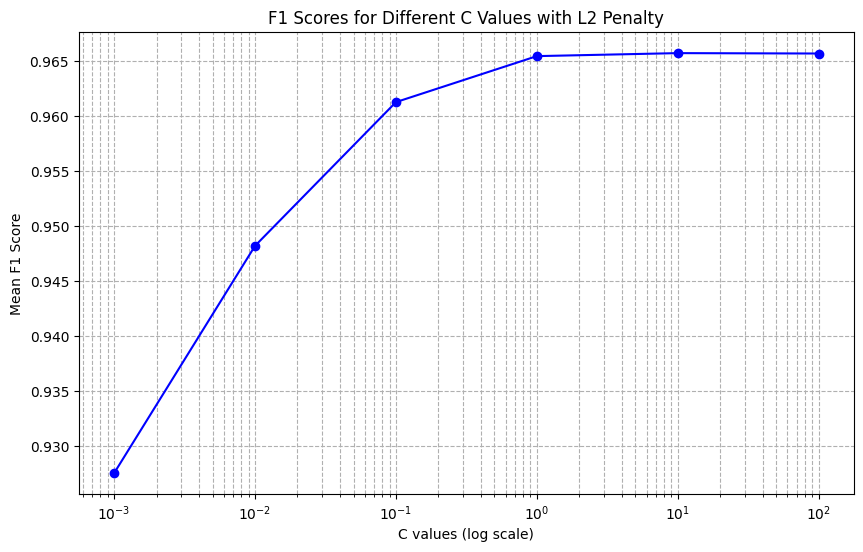

In [ ]:
mean_test_scores = logistic_grid.cv_results_['mean_test_score']

plt.figure(figsize=(10, 6))
plt.plot(logistic_params['C'], mean_test_scores, marker='o', linestyle='-', color='b')
plt.xscale('log')
plt.xlabel('C values (log scale)')
plt.ylabel('Mean F1 Score')
plt.title('F1 Scores for Different C Values with L2 Penalty')
plt.grid(True, which="both", ls="--")
plt.show()

In [ ]:
import joblib

# Save the trained logistic regression model
joblib.dump(logistic_grid.best_estimator_, 'logistic_model.pkl')

['logistic_model.pkl']

In [ ]:
|